# Import Toolkit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AI_Advanced_CK/CNN') # Chỉ định nơi làm việc (terminal)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

In [ ]:
!pip install torchsummary

# Model

## Model


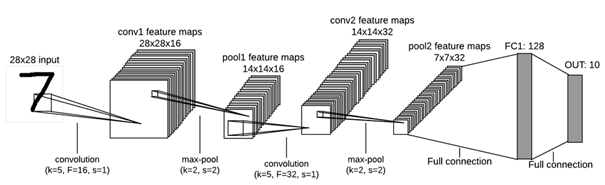

In [ ]:
from torchsummary import summary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # KHAI BÁO CÁO LỚP
        # conv1 có in_channels = 1 (hiện tại là ảnh gray , có thể chỉnh lên 3 được )
        # out_channels là F (như trong hình)
        # kernel_size là k (như trong hình) (kernel_size=3 là kích thướt 3x3 , là mấy kernel phía trên thầy cho,
        # còn dưới kiến trúc kernel_size k = 5 thì không dùng, đổi lại thành 3 để dùng mấy cái ma trận phía trên)
        # stride là s (như trong hình)
        # padding không có nhưng mà ta thấy giữ nguyên được W và H sau khi qua Conv thì p = s hoặc p = same
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # padding = same ?
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10) # 10 nhãn
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.feature_maps = []

    # SỬ DỤNG CÁC LỚP
    def forward(self, x):
        x = F.relu(self.conv1(x))
        self.feature_maps.append(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        self.feature_maps.append(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7) # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Khởi tạo mô hình
model = SimpleCNN()

## Model Summary

In [ ]:
from torchsummary import summary
# Move the model to the GPU
showmodel = SimpleCNN()
showmodel = showmodel.cuda()
# model = model.cpu()
# Then, summarize the model
summary(showmodel, (1, 28, 28)) # 1, 28, 28 là ảnh gray đầu vào

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Linear-5                  [-1, 128]         200,832
            Linear-6                   [-1, 10]           1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.79
Estimated Total Size (MB): 0.97
----------------------------------------------------------------


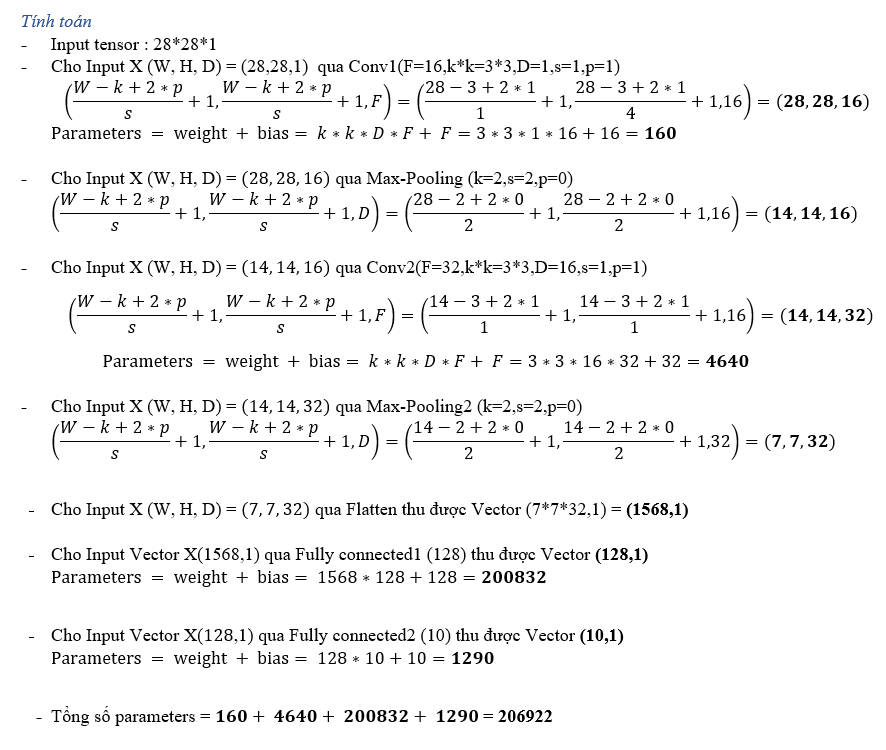

### b)Show Shape Flatten

In [ ]:
print(model.fc1.weight.shape)

torch.Size([128, 1568])


## Custom weight

```python
# Identity
w = [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]

# Edge Detection
w = [[1, 0, -1],
     [0, 0, 0],
     [-1, 0, 1]]

w = [[0, 1, 1],
     [1, -4, 0],
     [0, 1, 1]]

w = [[-1, -1, -1],
     [-1, 8, -1],
     [-1, -1, -1]]
```

In [ ]:
# Khởi tạo với một số trọng số cụ thể cho lớp tích chập đầu tiên (conv1) và các trọng số ngẫu nhiên cho các lớp khác (conv2).
def custom_init_weights(model):
    # init weight
    with torch.no_grad():
        # Custom weights conv1
        w = [[-1, -1, -1],
            [-1, 8, -1],
            [-1, -1, -1]]
        custom_kernel = torch.tensor([[w]], dtype=torch.float32)
        repeated_kernel = custom_kernel.repeat(model.conv1.out_channels, 1, 1, 1)
        model.conv1.weight.copy_(repeated_kernel)

        # Khởi tạo trọng số cho conv2 một cách ngẫu nhiên
        nn.init.kaiming_normal_(model.conv2.weight)
        nn.init.constant_(model.conv2.bias, 0.0)

        # Nhiều lớp thì cứ làm tương tự , xem ở file Manh_CNN_Example.ipynb

# Tùy chỉnh kernel đầu vào
custom_init_weights(model)

## Show weight

In [ ]:
# Kiểm tra kernel đầu vào
print(model.conv1.weight.shape)
print(model.conv1.weight[0])

print(model.conv2.weight.shape)
# print(model.conv2.weight[0])

torch.Size([16, 1, 3, 3])
tensor([[[-1., -1., -1.],
         [-1.,  8., -1.],
         [-1., -1., -1.]]], grad_fn=<SelectBackward0>)
torch.Size([32, 16, 3, 3])


# a)Map feature map

In [ ]:
def plot_feature_maps(feature_maps, num_columns=8):
    for idx, fmap in enumerate(feature_maps):
        fmap = fmap.detach().cpu().numpy()
        num_filters = fmap.shape[1]

        # Tính toán số hàng cần thiết
        num_rows = (num_filters + num_columns - 1) // num_columns

        fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 2, num_rows * 2))
        fig.suptitle(f'Layer {idx+1} Feature Maps')

        for i in range(num_filters):
            row = i // num_columns
            col = i % num_columns
            ax = axes[row, col]
            ax.imshow(fmap[0, i])
            # ax.imshow(fmap[0, i], cmap='gray')
            ax.axis('off')

        # Ẩn các ô trống nếu có
        for i in range(num_filters, num_rows * num_columns):
            row = i // num_columns
            col = i % num_columns
            ax = axes[row, col]
            ax.axis('off')

        plt.show()


In [ ]:
from torchvision import datasets, transforms
from PIL import Image

def load_image(image_path):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Chuyển đổi thành ảnh xám nếu cần
        transforms.Resize((28, 28)),  # Resize ảnh về kích thước 28x28
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    image = Image.open(image_path)
    image = transform(image)
    return image


In [ ]:
print(model.fc1.weight.shape)

torch.Size([128, 1568])


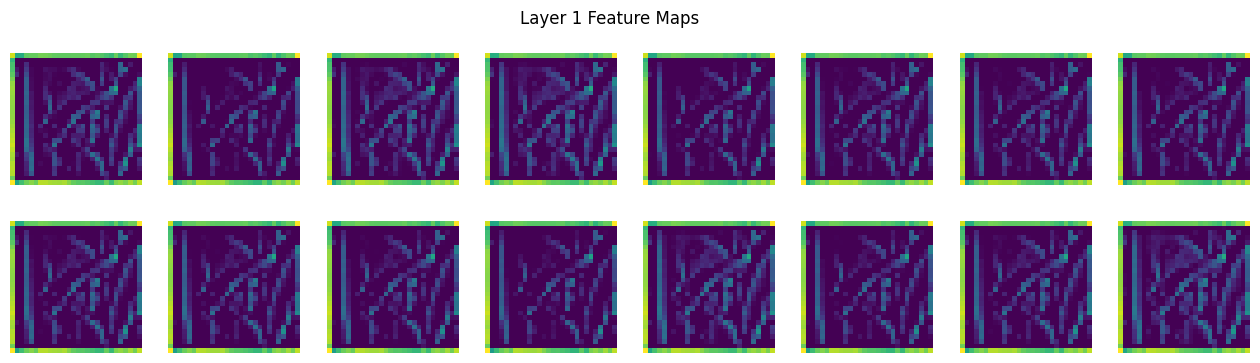

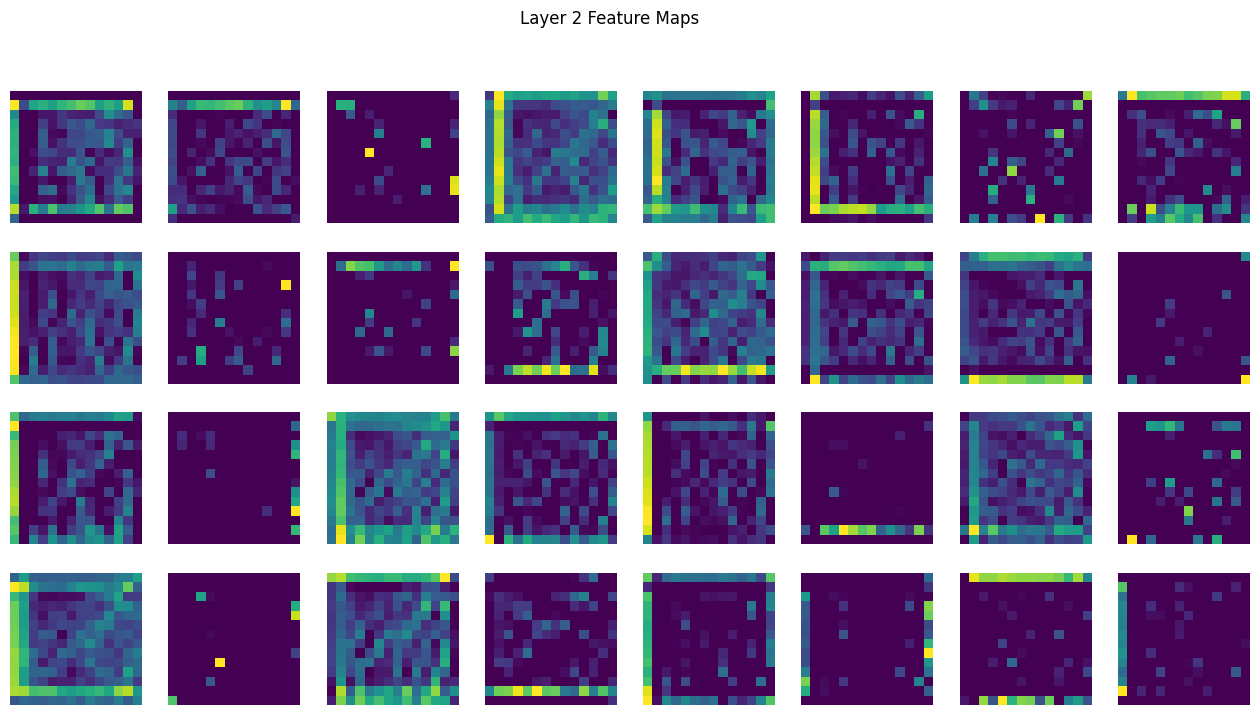

In [ ]:
# # Khởi tạo mô hình và tải trọng số đã huấn luyện (nếu có)
# model = SimpleCNN()

# Đọc ảnh từ file
image_path = './input_image.png'  # Thay thế bằng đường dẫn tới ảnh của bạn
image = load_image(image_path)

# Xóa feature maps cũ trước khi forward
model.feature_maps = []

# Forward qua mô hình
output = model(image.unsqueeze(0))

# Hiển thị các feature maps
plot_feature_maps(model.feature_maps)

# Train Model

## c)Loss function

In [ ]:
def custom_mse_loss(output, target):
    loss = torch.mean((output - target) ** 2)
    return loss

## d,e)Optimizer function

In [ ]:
class SimpleSGDOptimizer:
    def __init__(self, params, lr=0.01):
        self.params = list(params)
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


In [ ]:
class AdamOptimizer:
  def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999):
    self.params = list(params)
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2

    self.iter = 0
    self.m = [0] * len(self.params)
    self.v = [0] * len(self.params)

  def step(self):
    self.iter += 1

    for i, param in enumerate(self.params):
      if param.grad is not None:
        self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * param.grad
        self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * param.grad ** 2

        m_hat = self.m[i] / (1 - self.beta1 ** self.iter)
        v_hat = self.v[i] / (1 - self.beta2 ** self.iter)

        param.data -= self.lr * m_hat / (v_hat**0.5 + 1e-7)

  def zero_grad(self):
    for param in self.params:
      if param.grad is not None:
        param.grad.zero_()

## Fit Model

### e)Show weight with eporch

In [ ]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Chuẩn bị dữ liệu MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra (validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

# Khởi tạo mô hình, hàm loss và optimizer
# model = SimpleCNN()

# OPTIMIZER FUNCTION
optimizer = SimpleSGDOptimizer(model.parameters(), lr=0.01)
# optimizer = AdamOptimizer(model.parameters())

# Định nghĩa hàm tính toán độ chính xác
def calculate_accuracy(output, target):
    pred = output.argmax(dim=1)
    correct = (pred == target).float().sum()
    return correct / target.size(0)

# Huấn luyện mô hình
num_epochs = 5
for epoch in range(num_epochs):
    # Huấn luyện mô hình
    model.train()
    train_loss = 0
    train_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        model.feature_maps = []
        optimizer.zero_grad()
        output = model(data)

        # Chuyển đổi target thành one-hot vector
        target_one_hot = one_hot(target, num_classes=output.size(1)).float()

        # Tính toán loss
        loss = custom_mse_loss(output, target_one_hot)
        loss.backward()
        optimizer.step()

        # Cộng dồn loss và độ chính xác
        train_loss += loss.item()
        train_correct += calculate_accuracy(output, target).item()

        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item()}')

    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_loader)

    # Kiểm tra mô hình
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            target_one_hot = one_hot(target, num_classes=output.size(1)).float()
            loss = custom_mse_loss(output, target_one_hot)
            val_loss += loss.item()
            val_correct += calculate_accuracy(output, target).item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / len(val_loader)

    # In ra các giá trị loss và accuracy
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Print Weight sau mỗi eporch
    print(model.conv1.weight.shape)
    print(model.conv1.weight[0])
    # lớp convolution 2
    print(model.conv2.weight.shape)
    print(model.conv2.weight[0][0])
    # lớp fully connected 1
    print(model.fc1.weight.shape)
    print(model.fc1.weight[0:10])
    # lớp fully connected 2
    print(model.fc2.weight.shape)
    print(model.fc2.weight[0:10])

Epoch 1/5, Batch 0, Loss: 0.6761237382888794
Epoch 1/5, Batch 100, Loss: 0.06448552757501602
Epoch 1/5, Batch 200, Loss: 0.05272676423192024
Epoch 1/5, Batch 300, Loss: 0.045363180339336395
Epoch 1/5, Batch 400, Loss: 0.04184156283736229
Epoch 1/5, Batch 500, Loss: 0.04435327649116516
Epoch 1/5, Batch 600, Loss: 0.03268253803253174
Epoch 1/5, Batch 700, Loss: 0.039578843861818314
Epoch 1/5, Loss: 0.0558, Accuracy: 0.7535, Val Loss: 0.0372, Val Accuracy: 0.8654
torch.Size([16, 1, 3, 3])
tensor([[[-0.9983, -0.9985, -0.9992],
         [-0.9985,  8.0005, -0.9996],
         [-0.9985, -0.9988, -0.9991]]], grad_fn=<SelectBackward0>)
torch.Size([32, 16, 3, 3])
tensor([[-0.0155,  0.0998,  0.1513],
        [ 0.0341, -0.0650,  0.0616],
        [-0.0200,  0.0822,  0.2036]], grad_fn=<SelectBackward0>)
torch.Size([128, 1568])
tensor([[ 0.0217,  0.0060,  0.0064,  ...,  0.0107,  0.0138, -0.0144],
        [-0.0105,  0.0005,  0.0046,  ..., -0.0051,  0.0249, -0.0009],
        [-0.0186,  0.0054,  0.0215, 

### Evaluate

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            preds = output.argmax(dim=1, keepdim=True).squeeze()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    accuracy = accuracy_score(all_targets, all_preds)

    return precision, recall, f1, accuracy

# Đánh giá mô hình sau mỗi epoch
precision, recall, f1, accuracy = evaluate(model, train_loader)
print(f'Epoch {epoch+1}/{num_epochs}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}')

Epoch 5/5, Precision: 0.9320, Recall: 0.9313, F1: 0.9315, Accuracy: 0.9313


In [ ]:
def show_image_with_prediction(model, data_loader, index=0):
    model.eval()
    with torch.no_grad():
        data, target = next(iter(data_loader))
        image = data[index]
        true_label = target[index].item()

        output = model(image.unsqueeze(0))
        pred_label = output.argmax(dim=1, keepdim=True).item()

        image = image.squeeze().numpy()

        plt.imshow(image, cmap='gray')
        plt.title(f'True Label: {true_label}, Predicted Label: {pred_label}')
        if (true_label==pred_label):
            print('model dự đoán đúng')
        else:
            print('model dự đoán sai')
        plt.show()


model dự đoán đúng


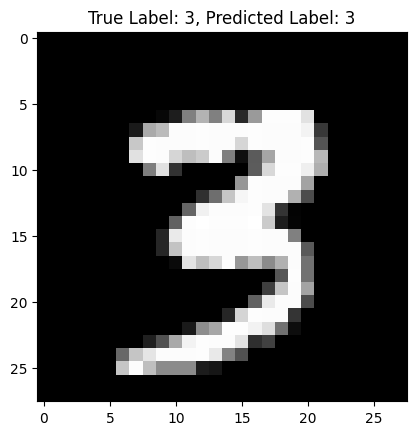

In [ ]:
# Hiển thị ảnh và dự đoán
show_image_with_prediction(model, train_loader, index=0)

### e)Show weight sau hội tụ

In [ ]:
# lớp convolution 1
print(model.conv1.weight.shape)
print(model.conv1.weight[0])
# lớp convolution 2
print(model.conv2.weight.shape)
print(model.conv2.weight[0][0])
# lớp fully connected 1
print(model.fc1.weight.shape)
print(model.fc1.weight[0:10])
# lớp fully connected 2
print(model.fc2.weight.shape)
print(model.fc2.weight[0:10])

torch.Size([16, 1, 3, 3])
tensor([[[-0.9930, -0.9937, -0.9963],
         [-0.9921,  8.0058, -0.9946],
         [-0.9932, -0.9925, -0.9929]]], grad_fn=<SelectBackward0>)
torch.Size([32, 16, 3, 3])
tensor([[-0.0147,  0.1008,  0.1499],
        [ 0.0305, -0.0687,  0.0614],
        [-0.0232,  0.0814,  0.1978]], grad_fn=<SelectBackward0>)
torch.Size([128, 1568])
tensor([[ 0.0217,  0.0060,  0.0064,  ...,  0.0107,  0.0138, -0.0144],
        [-0.0105,  0.0006,  0.0046,  ..., -0.0051,  0.0249, -0.0009],
        [-0.0191,  0.0024,  0.0196,  ...,  0.0015,  0.0233,  0.0074],
        ...,
        [ 0.0134, -0.0198,  0.0094,  ..., -0.0020, -0.0048,  0.0112],
        [-0.0009,  0.0161,  0.0163,  ..., -0.0105,  0.0219,  0.0117],
        [ 0.0201, -0.0190, -0.0089,  ..., -0.0150, -0.0174, -0.0044]],
       grad_fn=<SliceBackward0>)
torch.Size([10, 128])
tensor([[-0.0579, -0.0776, -0.0208,  ...,  0.0143, -0.0101,  0.0346],
        [-0.0822,  0.0612,  0.0795,  ..., -0.0493, -0.0225,  0.0776],
        [ 0.